In [1]:
import pandas as pd
import json
from etna.datasets import TSDataset

def seed_everything(seed: int):
    import random, os
    import numpy as np

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2025)

HORIZON = 366
N_FOLDS = 1

YEARLY_SEASONALITY = 365.25 # Каждый год это примерно столько дней

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:35: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:49: UserWarning: etna[chronos] is not available, to install it, run `pip install etna[chronos]`
  warnings.warn("etna[chronos] is not available, to install it, run `pip install etna[chronos]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:64: UserWarning: etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`
  warnings.warn("etna[timesfm] is not available, to install it, run `pip install etna[timesfm]`")
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\settings.py:72: UserWarning: wandb is not available, to install it, run `p

# 1. Подготовка данных (10 баллов)

Подготовим данные в формате ETNA

In [2]:
df = pd.read_parquet(
    "https://gist.githubusercontent.com/martins0n/86ca7e632a57bb1faefa98dc8e467d17/raw/2dfa5e6acf97ae2f6a587fc5e1c629836a8af16b/train.parquet"
)
df.head()


,segment,timestamp,target,country,store,product
0,Canada-TechWave-EchoWatch,2010-01-01,487.0,Canada,TechWave,EchoWatch
1,Canada-TechWave-ProTab,2010-01-01,454.0,Canada,TechWave,ProTab
2,Canada-TechWave-CoreX360,2010-01-01,212.0,Canada,TechWave,CoreX360
3,Canada-TechWave-ShadowX,2010-01-01,246.0,Canada,TechWave,ShadowX
4,Canada-GadgetOutlet-QuantumPhone,2010-01-01,149.0,Canada,Gadget Outlet,QuantumPhone


1. Приведем категориальные признаки к типу "category" -- при использовании модели Catboost, они будут автоматически подхватываться как категориальные(конкретно в ETNA так реализовано)

In [3]:
# Your code here
df["country"] = df["country"].astype("category")
df["store"] = df["store"].astype("category")
df["product"] = df["product"].astype("category")
df["segment"] = df["segment"].astype("category")

2. Разделим данные на таргет и доп данные(рассказывал на семинаре почему это важно)

In [4]:
df_exog = df.drop(columns=["target"])
y = df[["target"]]

3. Продлим доп данные в будущее -- так их можно будет использовать как регрессоры. Задача состоит в том чтобы в df_exog появились строчки для всех точек в будущем(на HORIZON или больше вперед) для всех доп данных, которые планируется использовать как регрессоры

Подсказки:
1. Можно сделать на чистом pandas
2. Можно сконструировать TSDataset, сгенерировать будущее и запонить пропуски через TimeSeriesImputerTransform(потом вернуться в pandas)

In [5]:
# Your code here
segments_df = pd.DataFrame({"segment": df_exog["segment"].unique()})
segments_df["key"] = 1

# Последняя дата + будущие даты
last_date = df_exog["timestamp"].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=HORIZON, freq="D")

future_dates_df = pd.DataFrame({"timestamp": future_dates})
future_dates_df["key"] = 1

# Декартово произведение: сегменты × будущие даты
future_rows = (
    future_dates_df.merge(segments_df, on="key")
    .drop(columns="key")
)
future_rows[["country", "store", "product"]] = future_rows["segment"].str.split("-", expand=True)
future_rows
df_exog = pd.concat([df_exog, future_rows], ignore_index=True)
df_exog

,segment,timestamp,country,store,product
0,Canada-TechWave-EchoWatch,2010-01-01,Canada,TechWave,EchoWatch
1,Canada-TechWave-ProTab,2010-01-01,Canada,TechWave,ProTab
2,Canada-TechWave-CoreX360,2010-01-01,Canada,TechWave,CoreX360
3,Canada-TechWave-ShadowX,2010-01-01,Canada,TechWave,ShadowX
4,Canada-GadgetOutlet-QuantumPhone,2010-01-01,Canada,Gadget Outlet,QuantumPhone
...,...,...,...,...,...
225011,Singapore-PremiumDevices-QuantumPhone,2016-12-31,Singapore,PremiumDevices,QuantumPhone
225012,Singapore-PremiumDevices-EchoWatch,2016-12-31,Singapore,PremiumDevices,EchoWatch
225013,Singapore-PremiumDevices-ProTab,2016-12-31,Singapore,PremiumDevices,ProTab
225014,Singapore-PremiumDevices-CoreX360,2016-12-31,Singapore,PremiumDevices,CoreX360


In [6]:
df_exog["country"] = df_exog["country"].astype("category")
df_exog["store"] = df_exog["store"].astype("category")
df_exog["product"] = df_exog["product"].astype("category")
df_exog["segment"] = df_exog["segment"].astype("category")
df_exog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225016 entries, 0 to 225015
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   segment    225016 non-null  category      
 1   timestamp  225016 non-null  datetime64[ns]
 2   country    225016 non-null  category      
 3   store      225016 non-null  category      
 4   product    225016 non-null  category      
dtypes: category(4), datetime64[ns](1)
memory usage: 2.6 MB


In [7]:
result = {
    "df_exog_n_rows": df_exog.shape[0], # 225016
    "df_exog_n_columns": df_exog.shape[1], # 5
    "df_exog_country_dtype": df_exog["country"].dtype.__class__.__name__, # CategoricalDtype
    "df_exog_product_dtype": df_exog["product"].dtype.__class__.__name__, # CategoricalDtype
    "df_exog_store_dtype": df_exog["store"].dtype.__class__.__name__, # CategoricalDtype
    "df_exog_max_timestamp": df_exog["timestamp"].max().date().strftime('%Y-%m-%d'), # 2016-12-31
}
print(json.dumps(result))

{"df_exog_n_rows": 225016, "df_exog_n_columns": 5, "df_exog_country_dtype": "CategoricalDtype", "df_exog_product_dtype": "CategoricalDtype", "df_exog_store_dtype": "CategoricalDtype", "df_exog_max_timestamp": "2016-12-31"}


4. Сконструируем TSDataset -- добавим доп данные и обозначим какие них являются регрессорами

In [8]:
ts = TSDataset(
    df=df[["timestamp", "segment", "target"]],
    df_exog=df_exog,
    freq="D",
    known_future=["country", "store", "product"]
)

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\tsdataset.py:1088: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["target"].astype(np.float64)
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\tsdataset.py:314: UserWarning: Segment values doesn't have string type, given type is category. Segments will be converted to string.
  warnings.warn(
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\tsdataset.py:314: UserWarning: Segment values doesn't have string type, given type is category. Segments will be converted to string.
  warnings.warn(


In [9]:
result = {
    "n_segments": ts.describe()["num_segments"].min(), # 88
    "num_exogs": ts.describe()["num_exogs"].min(), # 3
    "num_regressors": ts.describe()["num_regressors"].min(), # 3
    "max_timestamp": ts.describe()["end_timestamp"].min().date().strftime('%Y-%m-%d') # "2015-12-31"
}
print(json.dumps(result))

{"n_segments": 88, "num_exogs": 3, "num_regressors": 3, "max_timestamp": "2015-12-31"}


# 2. Локальные модели(30 баллов)

Построим пайплайн, в котором для каждого ряда будет обучаться отдельная модель

Постройте пайплайн со следущими признаками и преобразованиями:
1. Посегментная стандартизация таргета(обратите ванимание на параметр `mode`)
2. День недели
3. Фурье признаки для годовой сезонности(используйте первые 3 компоненты ряда фурье)
4. Удалите из датасета лишние колонки(например доп данные, которые в нашем случае константы в рамках ряда)


Обратите внимание на параметр `out_column` -- по дефолту генерируется какое-то автоматическое название, но для интерпритируемости лучше передавать какие-то осмысленные значения(в тестах как раз это проверяется)

In [10]:
from etna.pipeline import Pipeline
from etna.transforms import FourierTransform, DateFlagsTransform, OneHotEncoderTransform, StandardScalerTransform, FilterFeaturesTransform, SegmentEncoderTransform

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Линейная модель

Признак "день недели" тут лучше закодировать через one-hot-encoding

In [11]:
from etna.models import LinearPerSegmentModel

In [12]:
cat_features = ["country", "product", "store"]

pipeline_linear_local = Pipeline(
    model=LinearPerSegmentModel(),
    transforms=[
        StandardScalerTransform(in_column="target", mode="per-segment"),
        DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, is_weekend=False, out_column="df"),
        FourierTransform(period=365.25, order=3, out_column="fourier"),
        OneHotEncoderTransform(in_column="df_day_number_in_week", out_column='ohe_week'),
        FilterFeaturesTransform(exclude=cat_features + ["df_day_number_in_week"]),
    ],
    horizon=HORIZON,
)


## 2.2 Градиентный бустинг

Здесь "день недели" можно отдельно не кодировать, он подхватится катбустом как категориальная переменная

In [13]:
from etna.models import CatBoostPerSegmentModel

In [14]:
pipeline_catboost_local = Pipeline(
    model=CatBoostPerSegmentModel(),
    transforms=[
        StandardScalerTransform(in_column="target", mode="per-segment"),
        DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, is_weekend=False, out_column="df"),
        FourierTransform(period=365.25, order=3, out_column="fourier"),
        FilterFeaturesTransform(exclude=cat_features),
    ],
    horizon=HORIZON,
)

## 2.3 Сравним качество на кросс-валидации

In [15]:
from etna.analysis import plot_backtest
from etna.metrics import SMAPE

Запуск бэктеста

In [16]:
seed_everything(2025)
backtest_result_linear_local = pipeline_linear_local.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)
backtest_result_catboost_local = pipeline_catboost_local.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Don

Оценим метрики

In [17]:
result = {
    "features_linear_local": sorted(backtest_result_linear_local["forecasts"][0].features), # ["fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "ohe_week_0", "ohe_week_1", "ohe_week_2", "ohe_week_3", "ohe_week_4", "ohe_week_5", "ohe_week_6", "target"]
    "smape_backtest_result_linear_local": backtest_result_linear_local['metrics']["SMAPE"].mean(), # 19.881156065876766
}
print(json.dumps(result))

{"features_linear_local": ["fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "ohe_week_0", "ohe_week_1", "ohe_week_2", "ohe_week_3", "ohe_week_4", "ohe_week_5", "ohe_week_6", "target"], "smape_backtest_result_linear_local": 19.881156065876766}


In [18]:
result = {
    "features_catboost_local": sorted(backtest_result_catboost_local["forecasts"][0].features), # ["df_day_number_in_week", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "target"]
    "smape_backtest_result_catboost_local": backtest_result_catboost_local['metrics']["SMAPE"].mean(), # 20.030560665552073
}
print(json.dumps(result))

{"features_catboost_local": ["df_day_number_in_week", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "target"], "smape_backtest_result_catboost_local": 20.145484151705663}


Построим картинку

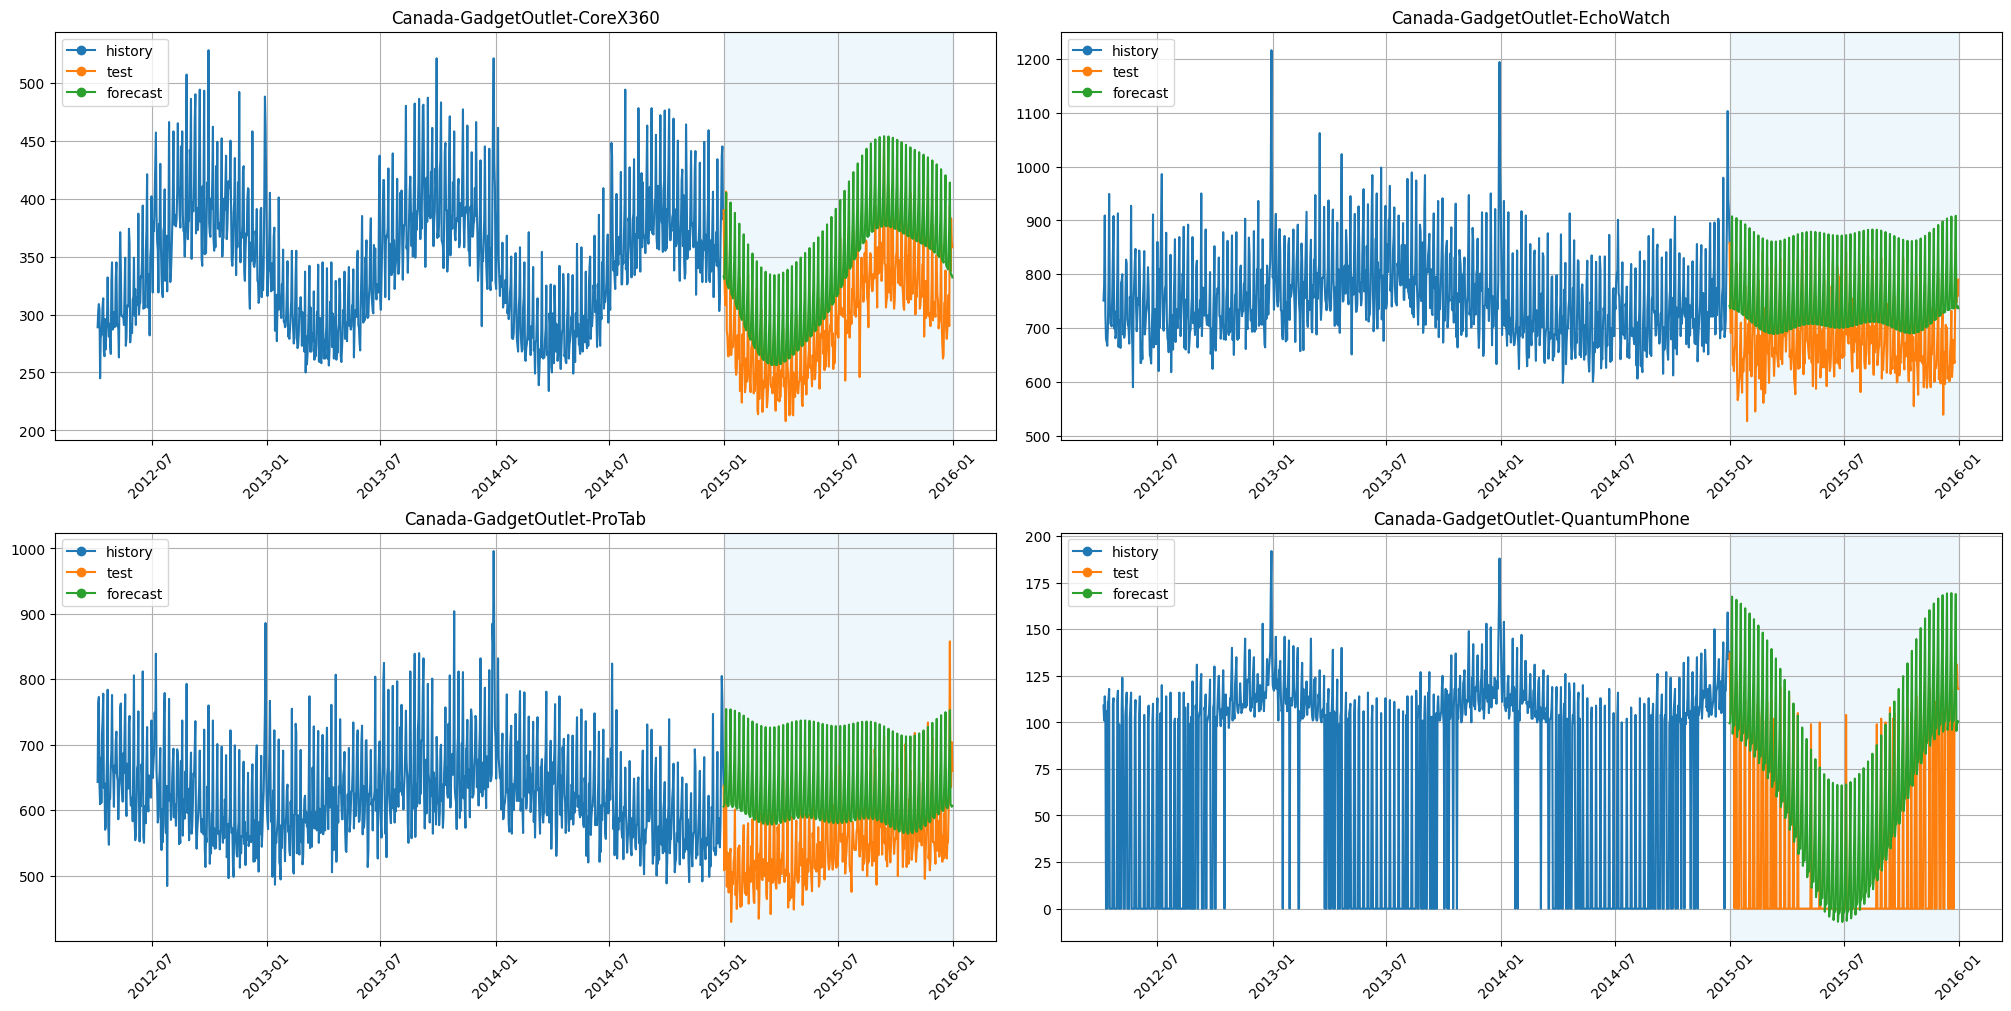

In [19]:
plot_backtest(
    forecast_ts_list=backtest_result_linear_local['forecasts'],
    ts=ts,
    history_len=1000,
    segments=ts.segments[:4]
)

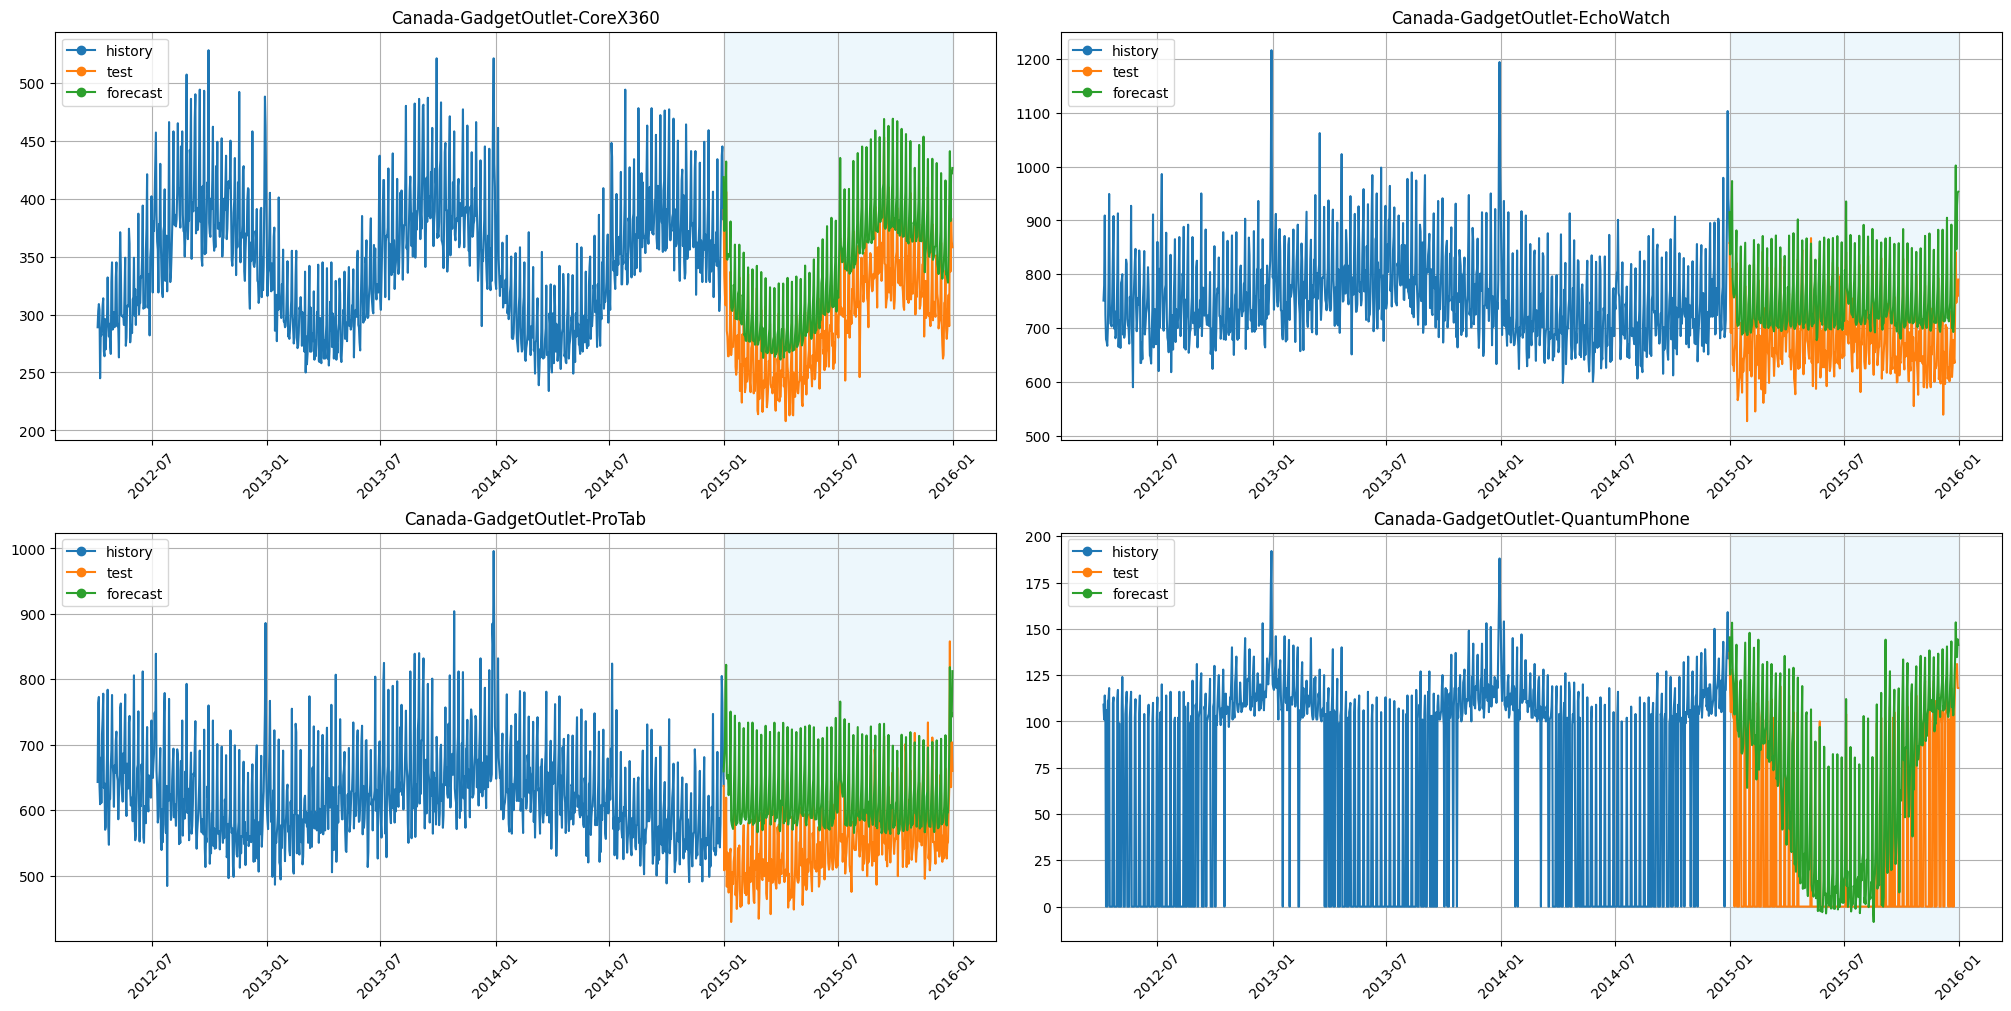

In [20]:
plot_backtest(
    forecast_ts_list=backtest_result_catboost_local['forecasts'],
    ts=ts,
    history_len=1000,
    segments=ts.segments[:4]
)

# 3. Глобальные модели(30 баллов)

Построим пайплайн, в котором для всех рядов учится одна модель

Постройте пайплайн со следущими признаками и преобразованиями
1. Глобальная стандартизация таргета(обратите ванимание на параметр `mode`)
2. День недели
3. Фурье признаки для годовой сезонности(используйте первые 3 компоненты ряда фурье)
4. Доп данные как признаки


Важное отличие от локальных моделей, это то что в датасет добавляются признаки, позволяющие отделить одни ряды от дургих(в данном случае, например, это страна)

## 3.1 Линейная модель

Признак "день недели" и все доп данные тут лучше закодировать через one-hot-encoding

In [21]:
from etna.models import LinearMultiSegmentModel

In [22]:
pipeline_linear_global = Pipeline(
    model=LinearMultiSegmentModel(),
    transforms=[
        StandardScalerTransform(in_column="target", mode='macro'),
        DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, is_weekend=False, out_column="df"),
        FourierTransform(period=365.25, order=3, out_column="fourier"),
        OneHotEncoderTransform(in_column="df_day_number_in_week", out_column='ohe_week'),
        OneHotEncoderTransform(in_column="country", out_column='country_ohe'),
        OneHotEncoderTransform(in_column="product", out_column='product_ohe'),
        OneHotEncoderTransform(in_column="store", out_column='store_ohe'),
        FilterFeaturesTransform(exclude=cat_features + ["df_day_number_in_week"]),
    ],
    horizon=HORIZON,
)

## 3.2 Градиентный бустинг

Здесь все категориальные переменные подхватятся катбустом автоматически

In [23]:
from etna.models import CatBoostMultiSegmentModel

In [24]:
pipeline_catboost_global = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=[
        StandardScalerTransform(in_column="target", mode="macro"),
        DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, is_weekend=False, out_column="df"),
        FourierTransform(period=365.25, order=3, out_column="fourier"),
    ],
    horizon=HORIZON,
)


## 2.3 Сравним качество на кросс-валидации

Запуск бэктеста

In [25]:
seed_everything(2025)
backtest_result_linear_global = pipeline_linear_global.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)
backtest_result_catboost_global = pipeline_catboost_global.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Don

Сравним метрики

In [26]:
result = {
    "features_linear_global": sorted(backtest_result_linear_global["forecasts"][0].features), # ["country_ohe_0", "country_ohe_1", "country_ohe_2", "country_ohe_3", "country_ohe_4", "country_ohe_5", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "ohe_week_0", "ohe_week_1", "ohe_week_2", "ohe_week_3", "ohe_week_4", "ohe_week_5", "ohe_week_6", "product_ohe_0", "product_ohe_1", "product_ohe_2", "product_ohe_3", "product_ohe_4", "store_ohe_0", "store_ohe_1", "store_ohe_2", "target"]
    "smape_backtest_result_linear_global": backtest_result_linear_global['metrics']["SMAPE"].mean(), # 61.020791666483795
}
print(json.dumps(result))

{"features_linear_global": ["country_ohe_0", "country_ohe_1", "country_ohe_2", "country_ohe_3", "country_ohe_4", "country_ohe_5", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "ohe_week_0", "ohe_week_1", "ohe_week_2", "ohe_week_3", "ohe_week_4", "ohe_week_5", "ohe_week_6", "product_ohe_0", "product_ohe_1", "product_ohe_2", "product_ohe_3", "product_ohe_4", "store_ohe_0", "store_ohe_1", "store_ohe_2", "target"], "smape_backtest_result_linear_global": 61.02079166648909}


In [27]:
result = {
    "features_catboost_global": sorted(backtest_result_catboost_global["forecasts"][0].features), # ["country", "df_day_number_in_week", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "product", "store", "target"]
    "smape_backtest_result_catboost_global": backtest_result_catboost_global['metrics']["SMAPE"].mean(), # 26.369243299479702
}
print(json.dumps(result))

{"features_catboost_global": ["country", "df_day_number_in_week", "fourier_1", "fourier_2", "fourier_3", "fourier_4", "fourier_5", "fourier_6", "product", "store", "target"], "smape_backtest_result_catboost_global": 26.255955818378798}


Построим картинки

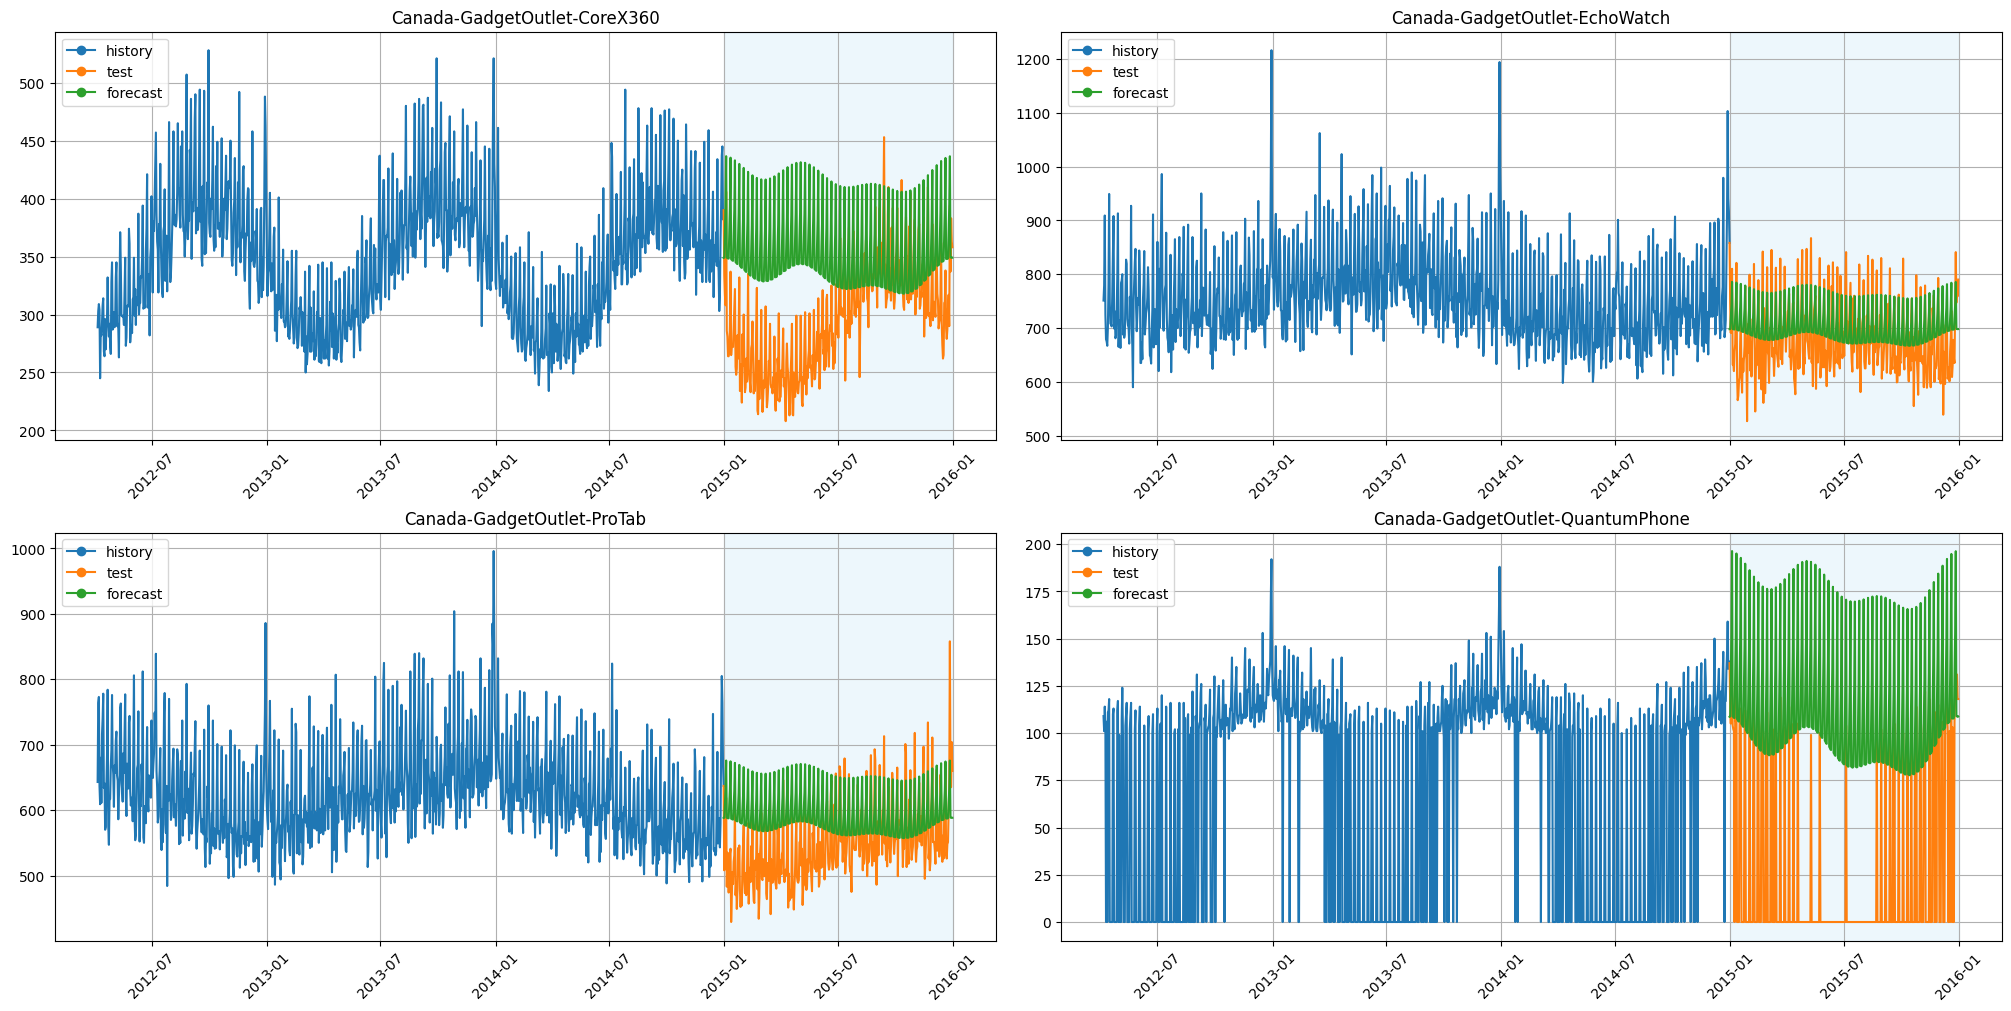

In [28]:
plot_backtest(
    forecast_ts_list=backtest_result_linear_global['forecasts'],
    ts=ts,
    history_len=1000,
    segments=ts.segments[:4]
)

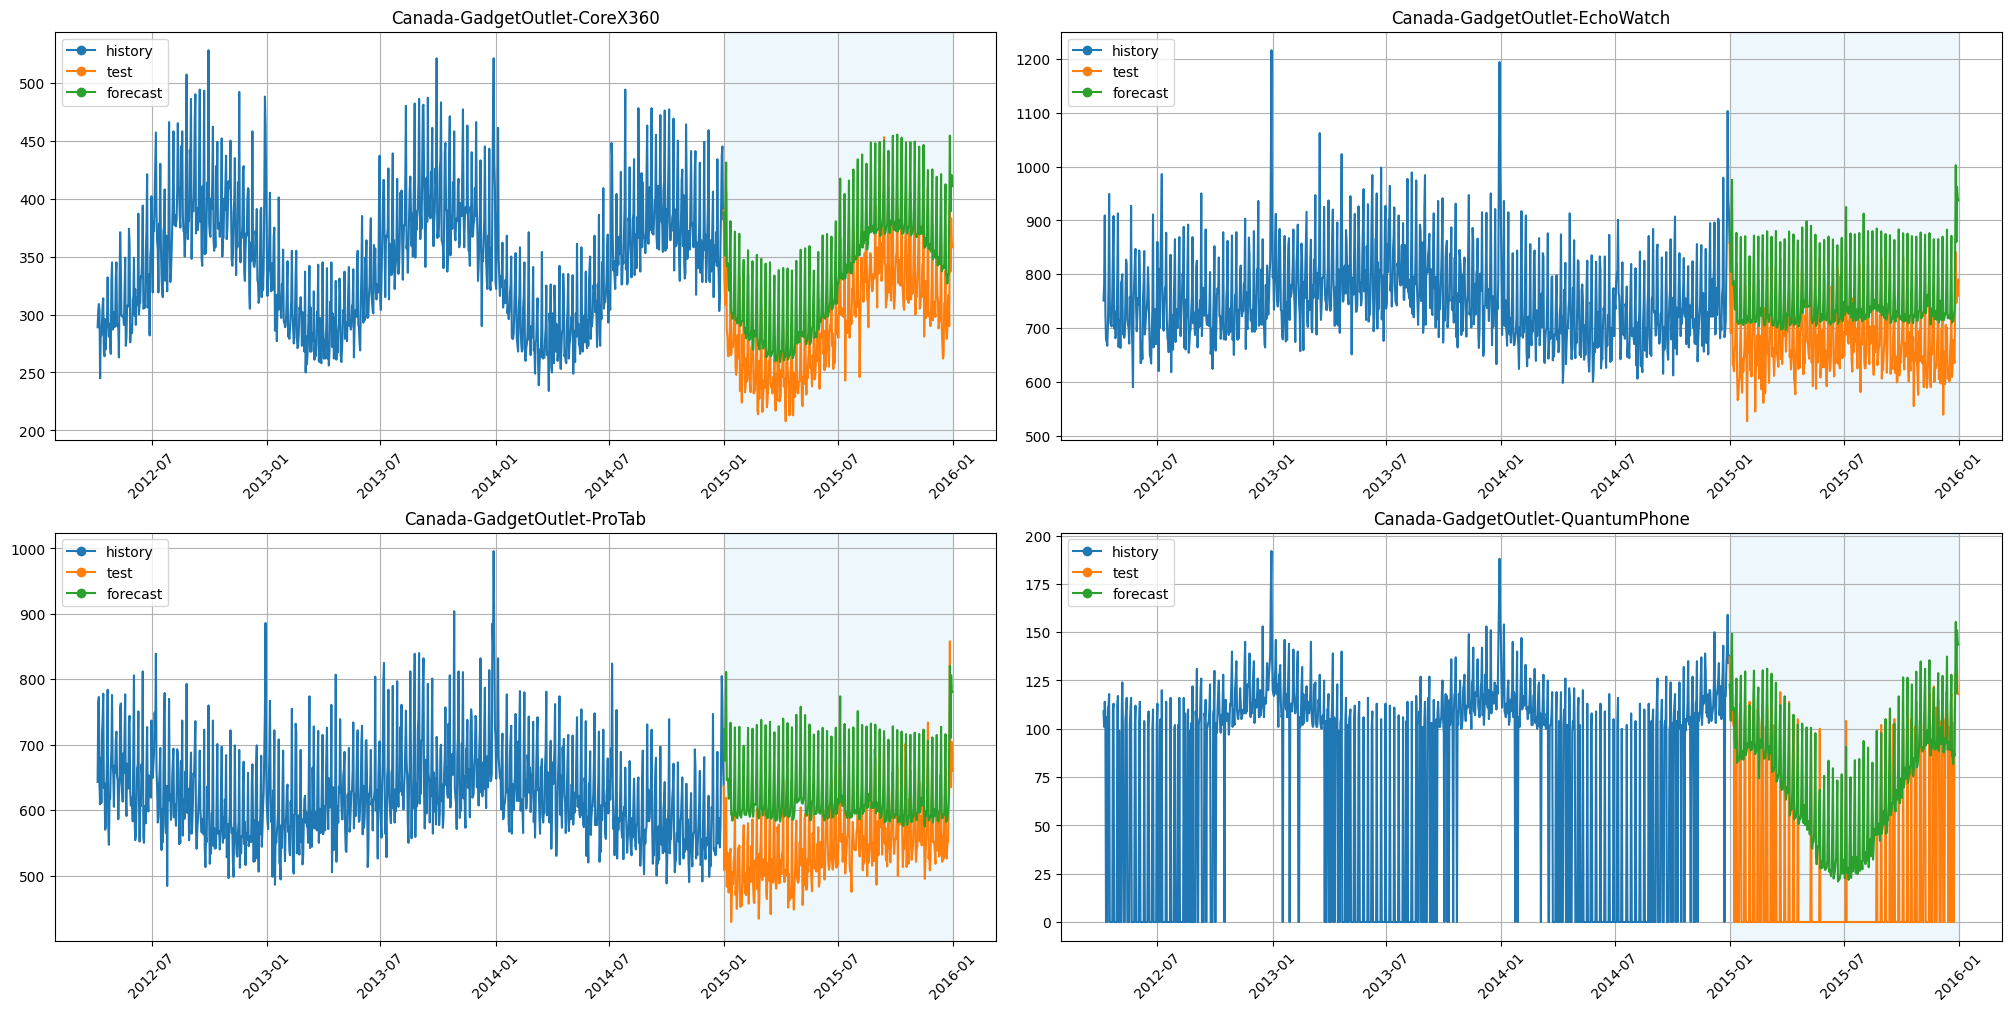

In [29]:
plot_backtest(
    forecast_ts_list=backtest_result_catboost_global['forecasts'],
    ts=ts,
    history_len=1000,
    segments=ts.segments[:4]
)

Метрики стали похуже, зато учится всего ОДНА модель. Ситуацию можно исправить(а может и нет) если:
1. Попробовать посегментную стандартизацию
2. Попробовать добавить больше признаков

# 4. Стратегии прогнозирования(30 баллов)

Локальные модели показали лучшее качество, теперь давайте подберем лучшую стратегию прогнозирования

В качестве признаков, будем использовать признаки, которые использовались в pipeline_linear_local с добавлением лаговых признаков -- будем использовать 7 ближайших

In [30]:
from etna.transforms import LagTransform

In [31]:
base_transforms = [
    StandardScalerTransform(in_column="target", mode="per-segment"),
    DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, is_weekend=False, out_column="df"),
    FourierTransform(period=365.25, order=3, out_column="fourier"),
    OneHotEncoderTransform(in_column="df_day_number_in_week", out_column='ohe_week'),
    FilterFeaturesTransform(exclude=cat_features + ["df_day_number_in_week"]),
]

## 4.1 Упрощенная прямая(Pipeline)

В упрошенной прямой стратегии мы можем использовать лаги, доступные на инференсе для последней точки горизонта

In [32]:
from etna.pipeline import Pipeline

In [33]:
long_lag =  LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 7)))# Your code here
pipeline = Pipeline(
    model=LinearPerSegmentModel(),
    transforms=base_transforms + [long_lag],
    horizon=HORIZON,
)

## 4.2 Авторегрессионная(AutoRegressivePipeline)

В авторегрессионной стратегии признаки перестраиваются с использоанием прогнозов на каждом шаге прогнозирования, поэтому мы можем использовать более близкие лаги. Попробуем вариант с шагом равным половине горизонта -- то есть прогноз будет состоять из 2 шагов

In [34]:
from etna.pipeline import AutoRegressivePipeline

In [35]:
short_lag = LagTransform(in_column="target", lags=[i for i in range(HORIZON//2, 7 + HORIZON//2)])
autoreg_pipeline = AutoRegressivePipeline(
    model=LinearPerSegmentModel(),
    transforms=base_transforms + [short_lag],
    horizon=HORIZON,
    step=HORIZON//2
)

## 4.3 Прямая(DirectEnsemble)

В прямой стратегии в пределе мы можем учить по 1 модели на каждую точки горизонта. Давайте попробуем учить 2 модели -- первая на перую половину, вторая на вторую. Для каждой модели используем соответствующие ближайшие лаги

In [36]:
from etna.ensembles import DirectEnsemble

In [37]:
horizons = [HORIZON//2, HORIZON]
pipeline_short = Pipeline(
    model=LinearPerSegmentModel(),
    transforms=base_transforms + [short_lag],
    horizon=horizons[0]
)
pipeline_long = Pipeline(
    model=LinearPerSegmentModel(),
    transforms=base_transforms + [long_lag],
    horizon=horizons[1]
)
direct_ensemble = DirectEnsemble(pipelines=[pipeline_short, pipeline_long])

## 4.4 Сравним качество на кросс-валидации

In [38]:
seed_everything(2025)
backtest_result_pipeline = pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)
backtest_result_autoreg = autoreg_pipeline.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)
backtest_result_direct = direct_ensemble.backtest(ts=ts, metrics=[SMAPE()], n_folds=N_FOLDS)

c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
c:\Users\chizh\Desktop\Магистратура\MLOps_course\ml_env\Lib\site-packages\etna\datasets\utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long["segment"] = np.repeat(a=segments, repeats=n_timestamps)
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Don

In [39]:
result = {
    "smape_backtest_result_linear_pipeline": backtest_result_pipeline['metrics']["SMAPE"].mean(), # 19.047149111188606
}
print(json.dumps(result))

{"smape_backtest_result_linear_pipeline": 19.047149111188606}


In [40]:
result = {
    "smape_backtest_result_linear_autoreg":backtest_result_autoreg['metrics']["SMAPE"].mean(), # 18.93854655111643
}
print(json.dumps(result))

{"smape_backtest_result_linear_autoreg": 18.938546551116435}


In [41]:
result = {
    "smape_backtest_result_linear_direct": backtest_result_direct['metrics']["SMAPE"].mean(), # 19.19755703592419
}
print(json.dumps(result))

{"smape_backtest_result_linear_direct": 19.197557035924188}
